
## Breaking is Bad
### Implementation of a Basic Crack Detector

The project aims to employ conventional techniques for the creation of a fundamental crack detection system, contributing to the automation of structural inspection processes. This endeavor is driven by the need to ensure the safety and reliability of various structures, in light of past incidents like the 2018 Ponte Morandi collapse. While structural health monitoring has been effective, the project seeks to enhance inspection capabilities through traditional methods.

### Section 1 : Importing Libraries

In [423]:
import os
import random
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage.morphology import skeletonize
from sklearn.ensemble import RandomForestClassifier

### Section 2 : Importing the annotations from CVAT tool

In [424]:
# After performing the annotation task from CVAT, we are using the exported file 
# We have used polyline and ellipse while annotating
xml_file_path = "annotations.xml" 
tree = ET.parse(xml_file_path)
root = tree.getroot()

In [425]:
# Setting a function for our module to parse the points out of annotations
def parse_points(points_str):
    points = points_str.strip().split(";")
    points = [tuple(map(float, point.split(","))) for point in points]
    return points

In [426]:
# Setting a function for our module to parse the ellipse out of annotations
def parse_ellipse(ellipse_str):
    params = ellipse_str.strip().split(",")
    if len(params) == 5:
        cx, cy, major_axis, minor_axis, angle = map(float, params)
        return (cx, cy, major_axis, minor_axis, angle)
    else:
        return None

In [427]:
# Here we would save the annotations in a dictionary
image_annotations = {}

In [428]:
# Extracting the annotation information from xml

for image_elem in root.findall(".//image"):
    image_id = int(image_elem.get("id"))
    image_name = image_elem.get("name")
    
    # Initializing a list to store annotations for this image
    annotations = []
    
    # Iterating through polyline and ellipse elements
    for annotation_elem in image_elem.findall(".//polyline") + image_elem.findall(".//ellipse"):
        label = annotation_elem.get("label")
        points = annotation_elem.get("points")
        
        # Appending the annotation as a dictionary to the list
        annotations.append({
            "label": label,
            "points": points,
        })
    
    # Storing the annotations for this image in the dictionary
    image_annotations[image_id] = {
        "image_name": image_name,
        "annotations": annotations,
    }


In [429]:
print(image_annotations)

{0: {'image_name': '0c377323-c884-44f4-b9e1-5698521ad20a.JPG', 'annotations': [{'label': 'Crack', 'points': '672.92,1411.69;653.17,1377.12;638.35,1354.07;628.48,1322.80;648.23,1288.23;661.40,1260.25;648.23,1225.68;672.92,1192.76;674.57,1171.36;669.63,1136.79'}, {'label': 'Crack', 'points': '672.48,242.95;677.11,219.14;671.16,209.87;675.79,195.32;677.77,176.14;683.73,162.24'}, {'label': 'Crack', 'points': '673.16,1136.52;682.68,1101.59;681.09,1077.77;667.60,1042.84;673.16,1000.77;656.48,988.07;638.23,969.02;642.20,940.44;633.46,928.53;623.94,903.92;623.14,872.17;619.17,847.56;612.82,826.13;621.56,809.46;631.08,800.72'}, {'label': 'Crack', 'points': '619.17,791.99;612.82,765.00;601.71,748.33;589.01,730.87;594.57,711.02;598.53,690.38;600.12,677.68;581.86,655.45;578.69,637.19;573.93,611.00;589.01,567.34;598.53,538.76;600.92,518.91;596.15,505.42;600.92,487.16;608.85,463.35;616.79,437.15;626.32,410.95;635.05,395.08'}, {'label': 'Crack', 'points': '641.39,389.15;651.97,377.24;647.34,356.07;64

In [430]:
print(image_annotations[0]['annotations'])

[{'label': 'Crack', 'points': '672.92,1411.69;653.17,1377.12;638.35,1354.07;628.48,1322.80;648.23,1288.23;661.40,1260.25;648.23,1225.68;672.92,1192.76;674.57,1171.36;669.63,1136.79'}, {'label': 'Crack', 'points': '672.48,242.95;677.11,219.14;671.16,209.87;675.79,195.32;677.77,176.14;683.73,162.24'}, {'label': 'Crack', 'points': '673.16,1136.52;682.68,1101.59;681.09,1077.77;667.60,1042.84;673.16,1000.77;656.48,988.07;638.23,969.02;642.20,940.44;633.46,928.53;623.94,903.92;623.14,872.17;619.17,847.56;612.82,826.13;621.56,809.46;631.08,800.72'}, {'label': 'Crack', 'points': '619.17,791.99;612.82,765.00;601.71,748.33;589.01,730.87;594.57,711.02;598.53,690.38;600.12,677.68;581.86,655.45;578.69,637.19;573.93,611.00;589.01,567.34;598.53,538.76;600.92,518.91;596.15,505.42;600.92,487.16;608.85,463.35;616.79,437.15;626.32,410.95;635.05,395.08'}, {'label': 'Crack', 'points': '641.39,389.15;651.97,377.24;647.34,356.07;649.33,338.87;655.28,328.95;663.88,317.70;667.19,293.23;669.83,278.01;675.79,255

### Section 3 : Saving the annotations from CVAT tool for view

In [431]:
image_paths = []
annotations_list = []

In [432]:
for image_id, image_info in image_annotations.items():
    # Constructing the image path
    image_name = image_info['image_name']
    image_path = os.path.join("image/", image_name)

    # Appending the image path and annotations to the respective lists
    image_paths.append(image_path)
    annotations_list.append(image_info['annotations'])
print(image_paths)

['image/0c377323-c884-44f4-b9e1-5698521ad20a.JPG', 'image/0d1415c4-099c-477f-a290-fea11c9f873f.JPG', 'image/7aaef046-b790-4f97-a77c-19864009ff4d.JPG', 'image/IMG_9001.jpg', 'image/IMG_9003.jpg', 'image/IMG_9004.jpg', 'image/IMG_9005.jpg', 'image/IMG_9007.jpg', 'image/IMG_9008.jpg', 'image/IMG_9009.jpg', 'image/c04464a0-0f86-40e2-87d0-6e8d3b9d4066.JPG']


In [433]:
# Defining the folder to save the annotated images
output_folder = "reflecting_annotations"

# Creating the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Visualizing images with annotations
for i in range(len(image_paths)):
    image_path = image_paths[i]
    annotations = annotations_list[i]
    
    # Loading the image
    original_image = cv2.imread(image_path)

    # Horizontal flip 
    should_flip = False  
    if should_flip:
        image = cv2.flip(original_image, 1)  # 1 indicates horizontal flip
    else:
        image = original_image
    
    # Drawing annotations on the image
    for annotation in annotations:
        points_str = annotation['points']
        ellipse_str = annotation.get('ellipse', '')

        if points_str:
            points = parse_points(points_str)
            
            # Checking if the polygon is closed
            is_closed = points[0] == points[-1]

            # Drawing the polygon without connecting first and last points if it's not closed
            if not is_closed:
                points = points[:-1]  
            
            points = np.array(points, np.int32)
            cv2.polylines(image, [points], isClosed=is_closed, color=(0, 0, 255), thickness=2)

        if ellipse_str:
            ellipse = parse_ellipse(ellipse_str)
            if ellipse is not None:
                cx, cy, major_axis, minor_axis, angle = ellipse
                cv2.ellipse(image, (int(cx), int(cy)), (int(major_axis / 2), int(minor_axis / 2)), angle, 0, 360, (0, 255, 0), 2)
    
    # Displaying the image with annotations
    #cv2.imshow("Image with Annotations", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Saving the displayed image in the "reflecting_annotations" folder
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    output_path = os.path.join(output_folder, f"{image_name}_annotated.png")  
    cv2.imwrite(output_path, image)


### Section 4 : Splitting up the dataset

In [434]:
# Setting up our training and testing data in the ratio 80:20
train_image_paths, test_image_paths, train_annotations, test_annotations = train_test_split(
    image_paths, annotations_list, test_size=0.2, random_state=42
)

In [435]:
print(train_annotations)

[[{'label': 'Crack', 'points': '1.95,888.50;11.20,890.48;23.10,886.52;35.66,887.18;49.55,888.50;62.77,887.18;70.04,894.45;81.28,901.06;86.57,899.08;99.79,903.05;120.29,909.00;134.83,909.66;155.33,914.95;168.55,911.64;181.11,910.32;193.67,899.74;203.59,893.79;208.88,890.48;230.69,890.48;237.97,887.84;249.87,885.86;258.46,885.86;263.09,889.16;272.34,884.53;278.95,886.52;292.84,883.87'}, {'label': 'Crack', 'points': '628.61,880.48;623.28,880.48;619.54,881.20;615.65,883.79;611.19,886.10;604.71,889.98;601.25,891.71;595.06,892.14;586.99,889.55;583.97,885.95'}, {'label': 'Crack', 'points': '723.46,862.43;717.59,863.98;707.39,864.33;703.07,865.19;696.68,869.69;688.56,873.49;684.06,877.98;680.09,878.84;671.80,875.22;666.78,875.22;663.67,877.12;657.97,877.29;652.96,876.43;649.16,874.35;643.11,874.70;639.65,876.25;635.68,878.15'}, {'label': 'Crack', 'points': '852.97,842.91;845.80,842.91;841.32,841.41;836.90,843.59;821.08,842.58;815.76,848.34;808.84,847.18;805.82,849.92;793.43,849.62;789.96,850.7

### Section 5 : Data Augmentation (Horizontal flipping, Rotation & Contrast Adjustment)

In [436]:
# Defining the path to the augmented images folder
augmented_images_folder = 'augmented_images'

# Creating the folder if it doesn't exist
os.makedirs(augmented_images_folder, exist_ok=True)

def augment_image(image, annotations):
    
    # Applying horizontal flipping
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # Flip horizontally
        # Updating annotation points
        for annotation in annotations:
            points_str = annotation['points']
            if points_str:
                points = parse_points(points_str)
                for i in range(len(points)):
                    points[i] = (image.shape[1] - points[i][0], points[i][1])  
                annotation['points'] = ';'.join([f"{x},{y}" for x, y in points])
    
    # Randomly applying rotation (between -10 and 10 degrees)
    angle = random.uniform(-10, 10)
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    # Randomly adjusting contrast and brightness
    alpha = 1.0 + random.uniform(-0.2, 0.2)  # Contrast adjustment
    beta = random.uniform(-30, 30)  # Brightness adjustment
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return image, annotations

# Augmenting the training dataset
augmented_train_images = []
augmented_train_annotations = []
for idx, (image_path, annotations) in enumerate(zip(train_image_paths, train_annotations)):
    image = cv2.imread(image_path)
    augmented_image, augmented_annotations = augment_image(image, annotations)

    # Defining the path to save the augmented image
    image_filename = os.path.basename(image_path)
    augmented_image_path = os.path.join(augmented_images_folder, f'augmented_{idx}_{image_filename}')

    # Saving the augmented image
    cv2.imwrite(augmented_image_path, augmented_image)

    augmented_train_images.append(augmented_image)
    augmented_train_annotations.append(augmented_annotations)

In [437]:
# Displaying augmented images
for i, augmented_image in enumerate(augmented_train_images):
    #cv2.imshow(f"Augmented Image {i + 1}", augmented_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [438]:
print(train_annotations)

[[{'label': 'Crack', 'points': '897.05,888.5;887.8,890.48;875.9,886.52;863.34,887.18;849.45,888.5;836.23,887.18;828.96,894.45;817.72,901.06;812.4300000000001,899.08;799.21,903.05;778.71,909.0;764.17,909.66;743.67,914.95;730.45,911.64;717.89,910.32;705.33,899.74;695.41,893.79;690.12,890.48;668.31,890.48;661.03,887.84;649.13,885.86;640.54,885.86;635.9100000000001,889.16;626.6600000000001,884.53;620.05,886.52;606.1600000000001,883.87'}, {'label': 'Crack', 'points': '270.39,880.48;275.72,880.48;279.46000000000004,881.2;283.35,883.79;287.80999999999995,886.1;294.28999999999996,889.98;297.75,891.71;303.94000000000005,892.14;312.01,889.55;315.03,885.95'}, {'label': 'Crack', 'points': '175.53999999999996,862.43;181.40999999999997,863.98;191.61,864.33;195.92999999999995,865.19;202.32000000000005,869.69;210.44000000000005,873.49;214.94000000000005,877.98;218.90999999999997,878.84;227.20000000000005,875.22;232.22000000000003,875.22;235.33000000000004,877.12;241.02999999999997,877.29;246.039999999

### Section 6 : Dataset Statistics

Number of images: 11
Number of pixels: 65276343
Number of labeled pixels: 497


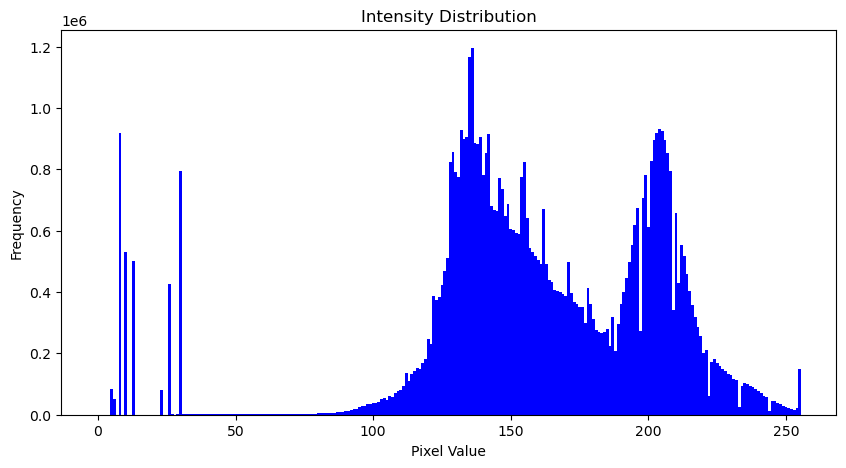

In [439]:
# Calculating dataset statistics
num_images = len(image_paths)
num_pixels = sum(image.shape[0] * image.shape[1] for image in augmented_train_images)

# Here we have considered histogram, number of pixels as statistics
# We will consider white pixels and annotated labels
# Calculating intensity distribution 
intensity_distribution = np.zeros(256, dtype=int)
for image in augmented_train_images:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    intensity_distribution += hist.flatten().astype(int)

# Calculating the number of labeled pixels
num_labeled_pixels = 0
for annotations in augmented_train_annotations:
    for annotation in annotations:
        points_str = annotation['points']
        if points_str:
            points = parse_points(points_str)
            num_labeled_pixels += len(points)

# Displaying basic statistics
print(f"Number of images: {num_images}")
print(f"Number of pixels: {num_pixels}")
print(f"Number of labeled pixels: {num_labeled_pixels}")

# Plotting intensity distribution histogram
plt.figure(figsize=(10, 5))
plt.bar(range(256), intensity_distribution, width=1.0, color='b')
plt.title('Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


Number of images: 8
Number of labeled pixels: 497


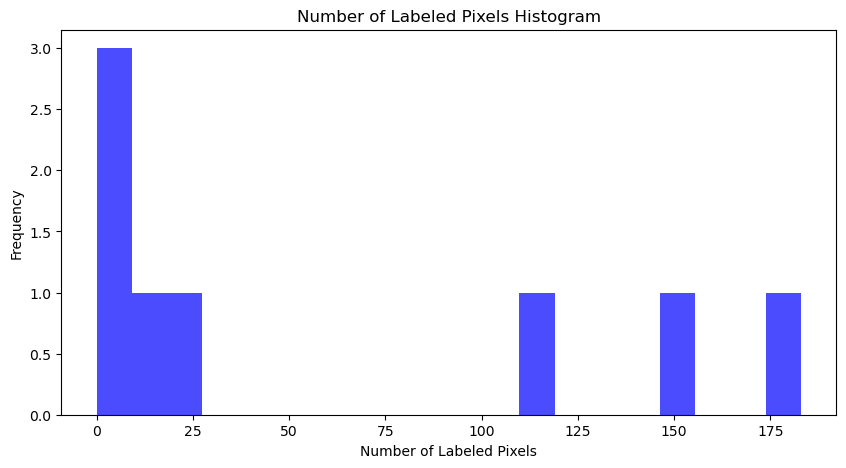

In [440]:
num_images = len(train_annotations)
num_labeled_pixels = 0

# Lists to store the number of labeled pixels for each image
num_labeled_pixels_per_image = []

# Iterate through each image's annotations
for annotations in train_annotations:
    image_labeled_pixels = 0
    for annotation in annotations:
        points_str = annotation.get('points', '') 
        if points_str:
            points = parse_points(points_str)
            image_labeled_pixels += len(points)
    num_labeled_pixels += image_labeled_pixels
    num_labeled_pixels_per_image.append(image_labeled_pixels)

# Display basic statistics
print(f"Number of images: {num_images}")
print(f"Number of labeled pixels: {num_labeled_pixels}")

# Plotting additional statistics
plt.figure(figsize=(10, 5))
plt.hist(num_labeled_pixels_per_image, bins=20, color='b', alpha=0.7)
plt.title('Number of Labeled Pixels Histogram')
plt.xlabel('Number of Labeled Pixels')
plt.ylabel('Frequency')
plt.show()

In [441]:
# Calculating the number of "crack" labels in each image
crack_counts = {}

for image_path, annotations in zip(train_image_paths, train_annotations):
    image_name = os.path.basename(image_path)
    crack_count = sum(1 for annotation in annotations if annotation['label'] == 'Crack')
    crack_counts[image_name] = crack_count

# Displaying the number of "crack" labels in each image
for image_name, count in crack_counts.items():
    print(f"Image: {image_name}, Number of 'Crack' labels: {count}")


Image: c04464a0-0f86-40e2-87d0-6e8d3b9d4066.JPG, Number of 'Crack' labels: 7
Image: 7aaef046-b790-4f97-a77c-19864009ff4d.JPG, Number of 'Crack' labels: 2
Image: 0d1415c4-099c-477f-a290-fea11c9f873f.JPG, Number of 'Crack' labels: 19
Image: IMG_9008.jpg, Number of 'Crack' labels: 0
Image: IMG_9003.jpg, Number of 'Crack' labels: 2
Image: IMG_9007.jpg, Number of 'Crack' labels: 2
Image: IMG_9001.jpg, Number of 'Crack' labels: 18
Image: IMG_9005.jpg, Number of 'Crack' labels: 0


### Section 7 : Binary Segmentation

In [442]:
# Setting masking for the images
mask_dir = 'masks/'
os.makedirs(mask_dir, exist_ok=True)

In [443]:
# Function to filter annotations and create a binary mask with Crack areas outlined in white
def segment_cracks(image, annotations):
    # Creating an empty binary mask with a black background
    binary_mask = np.zeros_like(image, dtype=np.uint8)

    # Filtering annotations to keep only "Crack" labels
    for annotation in annotations:
        label = annotation['label']
        if label == 'Crack':
            points_str = annotation['points']
            if points_str:
                points = parse_points(points_str)
                if len(points) >= 2:  
                    for i in range(len(points) - 1):
                        cv2.line(binary_mask, points[i], points[i+1], (255, 255, 255), 6)

    # Converting the binary mask to grayscale for considring brightness levels
    binary_mask_gray = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)

    # Morphological Operations to filter false positives
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask_gray, cv2.MORPH_OPEN, kernel)

    return cleaned_mask

# Function to parse points string into a list of (x, y) coordinates
# To extract the annotated points
def parse_points(points_str):
    points_list = []
    points_str = points_str.split(';')
    for point in points_str:
        x, y = map(float, point.split(','))
        points_list.append((int(x), int(y)))
    return points_list

output_folder = "segmented"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterating through the dictionary and process each image
for image_id, image_data in image_annotations.items():
    image_name = image_data['image_name']
    annotations = image_data['annotations']

    image_path = "image/" + image_name
    image = cv2.imread(image_path)

    segmented_mask = segment_cracks(image, annotations)

    output_path = os.path.join(output_folder, f"segmented_mask_{image_id}.png")
    cv2.imwrite(output_path, segmented_mask)


### Section 7 : Connected Component Analysis

In [444]:
# Reference: https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
# Since while annotating we make the big crack as sub-divided into small different cracks,
# the segmented and the connected results come as the same
def extract_regions(segmented_mask):
    
    # Applying connected component analysis to the binary mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_mask, connectivity=8)

    # Creating an empty mask to store individual regions
    region_mask = np.zeros_like(segmented_mask)

    # Iterating through each connected component (excluding background)
    for label in range(1, num_labels):
        # Creating a mask for the current component
        component_mask = (labels == label).astype(np.uint8) * 255

        # Adding the component_mask to the region_mask
        region_mask = cv2.add(region_mask, component_mask)

    return region_mask

# Creating a folder to save the region masks
if not os.path.exists("region_masks"):
    os.makedirs("region_masks")

# Iterating through the dictionary and process each image
for image_id, image_data in image_annotations.items():
    image_name = image_data['image_name']
    annotations = image_data['annotations']

    image_path = "image/" + image_name
    image = cv2.imread(image_path)

    # Calling the segment_cracks function to process the image
    segmented_mask = segment_cracks(image, annotations)

    # Performing connected component analysis and extract regions
    region_mask = extract_regions(segmented_mask)

    # Saving the region mask in the "region_masks" folder
    cv2.imwrite(f"region_masks/region_mask_{image_id}.png", region_mask)

In [445]:
# Checking values
num_region_pixels = 0
for row in range(region_mask.shape[0]):
    for col in range(region_mask.shape[1]):
        if region_mask[row, col] != 0:
            num_region_pixels += 1


In [446]:
print("Keys in image_annotations:", list(image_annotations.keys()))
#As during annotation we deleted one image which was blur

Keys in image_annotations: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]


In [447]:
def get_annotation_for_region(image_id, region_label):
    if image_id in image_annotations:
        annotations = image_annotations[image_id]['annotations']
        for annotation in annotations:
            if annotation['label'] == 'Crack':
                return "Crack"
            elif annotation['label'] == 'no-crack':
                return "no-crack"
    else:
        return "No-Image"


#image_id = 0  
#region_label = 0  
#annotation_label = get_annotation_for_region(image_id, region_label)
#print(f"Annotation for region {region_label} in image {image_id}: {annotation_label}")

In [448]:
# Reference : https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html

def calculate_region_properties(region_mask, image_id):
    
    # Calculating region properties using OpenCV
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(region_mask, connectivity=8)
    
    # Initializing lists to store feature vectors and labels
    feature_vectors = []
    assigned_labels = []
    
    # Iterating through each connected component (excluding background)
    for label in range(1, num_labels):
        # Extracting region properties from the stats array
        area = stats[label, cv2.CC_STAT_AREA]
        centroid = centroids[label]
        left = stats[label, cv2.CC_STAT_LEFT]
        top = stats[label, cv2.CC_STAT_TOP]
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]

        # Calculating circularity (example feature)
        circularity = (4.0 * np.pi * area) / (width * height * width * height)

        # Calculating color features (example: mean color)
        region_mean_color = np.mean(region_mask[top:top+height, left:left+width])

        # Creating a feature vector with selected properties
        feature_vector = [area, circularity, region_mean_color]

        # Check if the region has a "Crack" annotation in the image
        region_annotation = get_annotation_for_region(image_id, label)
        print('Image ID ' , image_id)
        print('Region_annotation ' , region_annotation)
        if region_annotation == "Crack":
            print('This image contains crack')
            assigned_label = "Crack"
        else:
            print('This image contains no-crack')
            assigned_label = "no-crack"

        # Appending the feature vector and assigned label to their respective lists
        feature_vectors.append(feature_vector)
        assigned_labels.append(assigned_label)

    return feature_vectors, assigned_labels

# Pathing to the folder containing region masks
region_masks_folder = "region_masks"


### Section 8 : Feature Engineering

In [449]:
# Initializing lists to store all feature vectors and labels from all images
all_feature_vectors = []
all_labels = []

# Iterating through region masks in the folder
for filename in os.listdir(region_masks_folder):
    if filename.endswith(".png"):
        # Loading the region mask
        region_mask = cv2.imread(os.path.join(region_masks_folder, filename), cv2.IMREAD_GRAYSCALE)
        parts = filename.split('_')
      #  print("filename ",filename)
      #  print("parts " ,parts)
      #  print("length ", len(parts))
        id = parts[2].split(".png")
        image_id = int(id[0])
     #   print("image_id ", id)

        # Calculating region properties and assign labels based on annotations
        if image_id != 7:
            feature_vectors, assigned_labels = calculate_region_properties(region_mask, image_id)

        # Extending the lists with feature vectors and labels from this image
        all_feature_vectors.extend(feature_vectors)
        all_labels.extend(assigned_labels)

# Now, all_feature_vectors contains feature vectors for all regions,
# and all_labels contains corresponding labels ("Crack" or "No-Crack").


Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  10
Region_annotation  Crack
This image contains crack
Image ID  11
Region_annotation  Crack
This image contains crack
Image ID  11
Region_annotation  Crack
This image contains crack
Image ID  11
Region_annotation  Crack
This image contains crack
Image ID  2
Region_annotation  Crack
This image contains crack
Image ID  3
Region_annotation  no-crack
This image contains no-crack
Image ID  3
Region_annotation  no-crack
This 

C:\Users\GOTTG\AppData\Local\Temp\ipykernel_15932\1237978453.py:23: RuntimeWarning: overflow encountered in int_scalars
  circularity = (4.0 * np.pi * area) / (width * height * width * height)


Image ID  3
Region_annotation  no-crack
This image contains no-crack
Image ID  3
Region_annotation  no-crack
This image contains no-crack
Image ID  3
Region_annotation  no-crack
This image contains no-crack
Image ID  3
Region_annotation  no-crack
This image contains no-crack
Image ID  3
Region_annotation  no-crack
This image contains no-crack
Image ID  8
Region_annotation  Crack
This image contains crack
Image ID  8
Region_annotation  Crack
This image contains crack
Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  0
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annotation  Crack
This image contains crack
Image ID  1
Region_annota

In [450]:
print(all_feature_vectors)

[[1058, 0.0038060713806183006, 144.34991974317816], [6942, -0.0001532910516255207, 29.000819134993446], [8106, -5.551700193369814e-05, 41.67399193548387], [671, 0.009791211497467445, 184.38038793103448], [3417, 0.001077074360431106, 138.00047513462147], [5044, 0.0005310581162708307, 117.73180778032037], [4229, 0.00031152628081339637, 82.56603629124875], [3187, 0.0008855383015262406, 120.8453531598513], [1353, 0.0041833731539617485, 171.13839285714286], [3546, 4.8153756891268924e-05, 29.724852071005916], [1470, 0.0020525072003453313, 124.95], [430, 0.012868511288709906, 169.21296296296296], [9054, -5.356296299795059e-05, 49.55292754120879], [4595, 0.00013305568831285477, 56.24639976958525], [526, 0.015266652523426717, 203.8449848024316], [706, 0.009015529125887722, 181.48185483870967], [985, 0.001424266095720644, 85.20183175033921], [331, 0.027346934078585707, 216.42307692307693], [631, 0.004877742319206851, 126.2], [996, 0.0017517466068454612, 95.01683501683502], [653, 0.00531961073328

In [451]:
binary_labels = [1 if label in [1, 2, 3, 4, 5, 6] else 0 for label in all_labels]

In [452]:
print(all_labels)

['Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'Crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'no-crack', 'Crack', 'Crack']


### Section 9 : Classifier - Decision Tree

In [453]:
X_train, X_test, y_train, y_test = train_test_split(
    all_feature_vectors, all_labels, test_size=0.2, random_state=42
)

In [454]:
clf = DecisionTreeClassifier(random_state=42)

In [455]:
clfRF = RandomForestClassifier(random_state=42)

In [456]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [457]:
clfRF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [458]:
y_pred = clf.predict(X_test)

In [459]:
y_predRF = clfRF.predict(X_test)

In [460]:
accuracy = accuracy_score(y_test, y_predRF)
report = classification_report(y_test, y_predRF, zero_division=1)

In [472]:
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

       Crack       0.71      0.56      0.63         9
    no-crack       0.50      0.67      0.57         6

    accuracy                           0.60        15
   macro avg       0.61      0.61      0.60        15
weighted avg       0.63      0.60      0.60        15



In [462]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

In [471]:
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

       Crack       0.71      0.56      0.63         9
    no-crack       0.50      0.67      0.57         6

    accuracy                           0.60        15
   macro avg       0.61      0.61      0.60        15
weighted avg       0.63      0.60      0.60        15



### Section 10 : Crack Analytics

In [464]:
def calculate_iou(gt_mask, predicted_mask):
    
    # Computing the intersection (logical AND) between the ground truth and predicted masks
    intersection = np.logical_and(gt_mask, predicted_mask)

    # Computing the union (logical OR) between the ground truth and predicted masks
    union = np.logical_or(gt_mask, predicted_mask)

    # Calculating IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou

In [465]:
# Reference : https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
# Reference : https://towardsdatascience.com/intersection-over-union-iou-calculation-for-evaluating-an-image-segmentation-model-8b22e2e84686

iou_scores = []

# Iterating through the images and calculating the IoU scores
for image_id in range(11):  #Keeping 11 here as the test scenario
    ground_truth_mask = cv2.imread(f"segmented/segmented_mask_{image_id}.png", cv2.IMREAD_GRAYSCALE)
    predicted_mask = cv2.imread(f"region_masks/region_mask_{image_id}.png", cv2.IMREAD_GRAYSCALE)

    # Keeping the masks as binary (0 and 255)
    _, ground_truth_mask = cv2.threshold(ground_truth_mask, 128, 255, cv2.THRESH_BINARY)
    _, predicted_mask = cv2.threshold(predicted_mask, 128, 255, cv2.THRESH_BINARY)

    # Calculating IoU score for the current image
    iou_score = calculate_iou(ground_truth_mask, predicted_mask)

    iou_scores.append(iou_score)

# Looping IoU scores for all images
for image_id, iou_score in enumerate(iou_scores):
    print(f"Image {image_id}: IoU Score = {iou_score}")
print('Images without crack and only no-crack labels show nan as count')

C:\Users\GOTTG\AppData\Local\Temp\ipykernel_15932\1155394533.py:10: RuntimeWarning: invalid value encountered in long_scalars
  iou = np.sum(intersection) / np.sum(union)


Image 0: IoU Score = 1.0
Image 1: IoU Score = 1.0
Image 2: IoU Score = 1.0
Image 3: IoU Score = 1.0
Image 4: IoU Score = nan
Image 5: IoU Score = nan
Image 6: IoU Score = nan
Image 7: IoU Score = 1.0
Image 8: IoU Score = 1.0
Image 9: IoU Score = nan
Image 10: IoU Score = 1.0
Images without crack and only no-crack labels show nan as count


### Section 11 : Thinning

In [466]:
# Reference : https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html

# We are saving the images in this folder for preview
thinned_folder = "thinned_images"
if not os.path.exists(thinned_folder):
    os.makedirs(thinned_folder)

# Iterating through the images and thinning each segmented mask
for image_id in range(11):  
    segmented_mask = cv2.imread(f"segmented/segmented_mask_{image_id}.png", cv2.IMREAD_GRAYSCALE)

  
    _, segmented_mask = cv2.threshold(segmented_mask, 128, 255, cv2.THRESH_BINARY)

    # Performing thinning using scikit-image
    thinned_mask = skeletonize(segmented_mask / 255).astype(np.uint8) * 255

    # Saving the thinned mask to the "thinned_images" folder
    output_path = os.path.join(thinned_folder, f"thinned_mask_{image_id}.png")
    cv2.imwrite(output_path, thinned_mask)

print("Thinning completed and thinned masks saved to the 'thinned_images' folder.")

Thinning completed and thinned masks saved to the 'thinned_images' folder.


### Section 12 : Computing Crack Lengths

In [467]:
# Reference : https://www.researchgate.net/publication/354336108_Crack_Length_Measurement_Using_Convolutional_Neural_Networks_and_Image_Processing

def compute_crack_length(thinned_mask):
    
    # Finding contours in the thinned mask
    contours, _ = cv2.findContours(thinned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initializing a variable to accumulate the total length of cracks
    total_length = 0.0

    # Iterating through each contour (crack) and computing its length
    for contour in contours:
        arc_length = cv2.arcLength(contour, closed=True)
        total_length += arc_length

    return total_length

In [468]:
crack_lengths = []

In [470]:
# Reference : https://www.researchgate.net/publication/354336108_Crack_Length_Measurement_Using_Convolutional_Neural_Networks_and_Image_Processing

for image_id in range(0, 8):  
    
    # Loading the thinned crack mask for the current image
    thinned_mask = cv2.imread(f"thinned_images/thinned_mask_{image_id}.png", cv2.IMREAD_GRAYSCALE)


    _, thinned_mask = cv2.threshold(thinned_mask, 128, 255, cv2.THRESH_BINARY)

    # Computing the length of cracks in the current image
    length = compute_crack_length(thinned_mask)


    crack_lengths.append(length)

    print(f"Crack length for image {image_id}: {length} pixels")
print('Images without crack and only no-crack labels show 0 as count')

Crack length for image 0: 2803.1109426021576 pixels
Crack length for image 1: 3105.7585709095 pixels
Crack length for image 2: 816.9848430156708 pixels
Crack length for image 3: 3595.8014137744904 pixels
Crack length for image 4: 0.0 pixels
Crack length for image 5: 0.0 pixels
Crack length for image 6: 0.0 pixels
Crack length for image 7: 3480.905764102936 pixels
Images without crack and only no-crack labels show 0 as count


### References

https://www.mdpi.com/2076-3417/13/15/8950